In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from datetime import datetime

# --- INFO UTILISATEUR ---
print("="*60)
print("PRÉPARATION COMPLÈTE DES DONNÉES COUPE DU MONDE")
print(f"Utilisateur : TN | Heure : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} CET")
print("="*60 + "\n")

# --- CHARGEMENT ---
df_matches = pd.read_csv('matches_1930_2022.csv')
df_ranking = pd.read_csv('fifa_ranking_2022-10-06.csv')
df_wc = pd.read_csv('world_cup.csv')

print("DATASETS CHARGÉS")
print(f"   • matches  : {df_matches.shape[0]} lignes × {df_matches.shape[1]} colonnes")
print(f"   • ranking  : {df_ranking.shape[0]} lignes × {df_ranking.shape[1]} colonnes")
print(f"   • world_cup: {df_wc.shape[0]} lignes × {df_wc.shape[1]} colonnes\n")

PRÉPARATION COMPLÈTE DES DONNÉES COUPE DU MONDE
Utilisateur : TN | Heure : 2025-11-26 18:03:29 CET

DATASETS CHARGÉS
   • matches  : 964 lignes × 44 colonnes
   • ranking  : 210 lignes × 7 colonnes
   • world_cup: 22 lignes × 9 colonnes



In [2]:
print("1) GESTION DES DOUBLONS")
print("-" * 50)

print(f"Doublons AVANT (matches) : {df_matches.duplicated().sum()}")
print(f"Doublons AVANT (ranking) : {df_ranking.duplicated().sum()}")
print(f"Doublons AVANT (wc)       : {df_wc.duplicated().sum()}")

df_matches.drop_duplicates(inplace=True)
df_ranking.drop_duplicates(inplace=True)
df_wc.drop_duplicates(inplace=True)

print(f"\nDoublons APRÈS (matches) : {df_matches.duplicated().sum()}")
print(f"Doublons APRÈS (ranking) : {df_ranking.duplicated().sum()}")
print(f"Doublons APRÈS (wc)       : {df_wc.duplicated().sum()}")

1) GESTION DES DOUBLONS
--------------------------------------------------
Doublons AVANT (matches) : 0
Doublons AVANT (ranking) : 0
Doublons AVANT (wc)       : 0

Doublons APRÈS (matches) : 0
Doublons APRÈS (ranking) : 0
Doublons APRÈS (wc)       : 0


In [3]:
print("\n2) GESTION DES VALEURS MANQUANTES")
print("-" * 50)

print(f"Manquants AVANT (matches) : {df_matches.isnull().sum().sum()}")
print(f"Manquants AVANT (ranking) : {df_ranking.isnull().sum().sum()}")
print(f"Manquants AVANT (wc)       : {df_wc.isnull().sum().sum()}")

df_matches['home_xg'] = df_matches['home_xg'].fillna(df_matches['home_xg'].median())
df_matches['away_xg'] = df_matches['away_xg'].fillna(df_matches['away_xg'].median())
df_matches['home_penalty'] = df_matches['home_penalty'].fillna(0)
df_matches['away_penalty'] = df_matches['away_penalty'].fillna(0)
df_matches['Attendance'] = df_matches['Attendance'].fillna(df_matches['Attendance'].median())
df_matches.fillna('Unknown', inplace=True)

print(f"\nManquants APRÈS (matches) : {df_matches.isnull().sum().sum()}")
print(f"Manquants APRÈS (ranking) : {df_ranking.isnull().sum().sum()}")
print(f"Manquants APRÈS (wc)       : {df_wc.isnull().sum().sum()}")


2) GESTION DES VALEURS MANQUANTES
--------------------------------------------------
Manquants AVANT (matches) : 20914
Manquants AVANT (ranking) : 0
Manquants AVANT (wc)       : 0

Manquants APRÈS (matches) : 0
Manquants APRÈS (ranking) : 0
Manquants APRÈS (wc)       : 0


In [4]:
print("\n3) CORRECTION DES TYPES")
print("-" * 50)

print("Types AVANT :")
print(df_matches[['home_score', 'away_score', 'Date']].dtypes)

df_matches['home_score'] = pd.to_numeric(df_matches['home_score'], errors='coerce').fillna(0).astype(int)
df_matches['away_score'] = pd.to_numeric(df_matches['away_score'], errors='coerce').fillna(0).astype(int)
df_matches['Date'] = pd.to_datetime(df_matches['Date'], errors='coerce')

print("\nTypes APRÈS :")
print(df_matches [['home_score', 'away_score', 'Date']].dtypes)


3) CORRECTION DES TYPES
--------------------------------------------------
Types AVANT :
home_score     int64
away_score     int64
Date          object
dtype: object

Types APRÈS :
home_score             int64
away_score             int64
Date          datetime64[ns]
dtype: object


In [5]:
print("2) NETTOYAGE DE BASE")
print("-" * 50)
df_matches['home_score'] = pd.to_numeric(df_matches['home_score'], errors='coerce').fillna(0).astype(int)
df_matches['away_score'] = pd.to_numeric(df_matches['away_score'], errors='coerce').fillna(0).astype(int)
df_matches['Date'] = pd.to_datetime(df_matches['Date'], errors='coerce')  # ← CORRIGÉ ICI
df_matches['home_score'] = df_matches['home_score'].clip(lower=0)
df_matches['away_score'] = df_matches['away_score'].clip(lower=0)
df_matches['home_xg'] = pd.to_numeric(df_matches['home_xg'], errors='coerce').fillna(df_matches['home_score'].mean())
df_matches['away_xg'] = pd.to_numeric(df_matches['away_xg'], errors='coerce').fillna(df_matches['away_score'].mean())
df_matches.fillna('Unknown', inplace=True)
print(f"Manquants APRÈS : {df_matches.isnull().sum().sum()}\n")

2) NETTOYAGE DE BASE
--------------------------------------------------
Manquants APRÈS : 0



In [6]:
# === PARTIE 3 : AJOUT DES RANKINGS ===
print("PARTIE 3 : Intégration des rankings")
print("-" * 50)
df_ranking = df_ranking.rename(columns={'team': 'team_name', 'rank': 'fifa_rank', 'points': 'fifa_points'})
home_ranks = df_ranking.set_index('team_name')['fifa_rank'].to_dict()
away_ranks = df_ranking.set_index('team_name')['fifa_rank'].to_dict()
home_points = df_ranking.set_index('team_name')['fifa_points'].to_dict()
away_points = df_ranking.set_index('team_name')['fifa_points'].to_dict()
df_matches['home_fifa_rank'] = df_matches['home_team'].map(home_ranks).fillna(df_ranking['fifa_rank'].mean())
df_matches['away_fifa_rank'] = df_matches['away_team'].map(away_ranks).fillna(df_ranking['fifa_rank'].mean())
df_matches['home_fifa_points'] = df_matches['home_team'].map(home_points).fillna(df_ranking['fifa_points'].mean())
df_matches['away_fifa_points'] = df_matches['away_team'].map(away_points).fillna(df_ranking['fifa_points'].mean())
print("Rankings ajoutés aux matchs")
print(df_matches[['home_team', 'home_fifa_rank', 'away_team', 'away_fifa_rank']].head(2))
print()

PARTIE 3 : Intégration des rankings
--------------------------------------------------
Rankings ajoutés aux matchs
   home_team  home_fifa_rank away_team  away_fifa_rank
0  Argentina             3.0    France             4.0
1    Croatia            12.0   Morocco            22.0



In [7]:
# === PARTIE 4 : AJOUT DES FEATURES WC HISTORIQUES ===
print("PARTIE 4 : Intégration de l'historique WC")
print("-" * 50)
df_wc['Champion'] = df_wc['Champion'].str.strip()
champions_count = df_wc['Champion'].value_counts().to_dict()
df_wc['TopScorrer_goals'] = df_wc['TopScorrer'].apply(
    lambda x: int(str(x).split('-')[-1].strip()) if '-' in str(x) else 0
)
avg_goals_wc = df_wc.groupby('Champion')['TopScorrer_goals'].mean().to_dict()
df_matches['home_wc_titles'] = df_matches['home_team'].map(champions_count).fillna(0)
df_matches['away_wc_titles'] = df_matches['away_team'].map(champions_count).fillna(0)
df_matches['home_avg_goals_wc'] = df_matches['home_team'].map(avg_goals_wc).fillna(df_wc['TopScorrer_goals'].mean())
df_matches['away_avg_goals_wc'] = df_matches['away_team'].map(avg_goals_wc).fillna(df_wc['TopScorrer_goals'].mean())
print("Features WC ajoutées")
print(df_matches[['home_team', 'home_wc_titles', 'away_team', 'away_wc_titles']].head(2))
print()

PARTIE 4 : Intégration de l'historique WC
--------------------------------------------------
Features WC ajoutées
   home_team  home_wc_titles away_team  away_wc_titles
0  Argentina             3.0    France             2.0
1    Croatia             0.0   Morocco             0.0



In [8]:
# === PARTIE 5 : OUTCOMES & WIN CONDITIONS (CORRIGÉ : Date → Date) ===
print("PARTIE 5 : Calcul des outcomes")
print("-" * 50)
def get_outcome(row):
    if row['home_score'] > row['away_score']: return 'Home Win'
    elif row['home_score'] < row['away_score']: return 'Away Win'
    else: return 'Draw'
df_matches['outcome'] = df_matches.apply(get_outcome, axis=1)
df_matches['winning_team'] = np.where(
    df_matches['home_score'] > df_matches['away_score'], df_matches['home_team'],
    np.where(df_matches['home_score'] < df_matches['away_score'], df_matches['away_team'], 'Draw')
)
df_matches['losing_team'] = np.where(
    df_matches['home_score'] > df_matches['away_score'], df_matches['away_team'],
    np.where(df_matches['home_score'] < df_matches['away_score'], df_matches['home_team'], 'Draw')
)
win_conditions_array = np.where(
    df_matches['Notes'].str.contains('extra time', case=False, na=False), 'extra time',
    np.where(df_matches['Notes'].str.contains('penalty', case=False, na=False), 'penalties', 'normal')
)
df_matches['win_conditions'] = pd.Series(win_conditions_array, index=df_matches.index).fillna('normal')
df_matches['month'] = df_matches['Date'].dt.strftime('%b')  # ← CORRIGÉ ICI
df_matches['dayofweek'] = df_matches['Date'].dt.day_name()   # ← CORRIGÉ ICI
df_matches['month_num'] = df_matches['Date'].dt.month       # ← CORRIGÉ ICI
print("Outcomes calculés avec succès !")
print(df_matches['win_conditions'].value_counts())
print()

PARTIE 5 : Calcul des outcomes
--------------------------------------------------
Outcomes calculés avec succès !
win_conditions
normal        891
extra time     73
Name: count, dtype: int64



In [9]:
# === PARTIE 6 : FEATURES AVANCÉES (CORRIGÉ : Date → Date) ===
print("PARTIE 6 : Ajout des features")
print("-" * 50)
df_matches = df_matches.sort_values('Date').reset_index(drop=True)  # ← CORRIGÉ ICI
df_matches['home_goals_last5'] = df_matches.groupby('home_team')['home_score'].transform(
    lambda x: x.rolling(5, min_periods=1).mean()
)
df_matches['away_goals_last5'] = df_matches.groupby('away_team')['away_score'].transform(
    lambda x: x.rolling(5, min_periods=1).mean()
)
df_matches['home_goals_last5'] = df_matches['home_goals_last5'].fillna(df_matches['home_score'].mean())
df_matches['away_goals_last5'] = df_matches['away_goals_last5'].fillna(df_matches['away_score'].mean())
df_matches['year'] = df_matches['Date'].dt.year  # ← CORRIGÉ ICI
df_matches['home_strength'] = df_matches.groupby(['home_team', 'year'])['home_score'].transform('mean')
df_matches['away_strength'] = df_matches.groupby(['away_team', 'year'])['away_score'].transform('mean')
df_matches['home_strength'] = df_matches['home_strength'].fillna(df_matches['home_score'].mean())
df_matches['away_strength'] = df_matches['away_strength'].fillna(df_matches['away_score'].mean())
df_matches['is_group_stage'] = df_matches['Round'].str.contains('Group', case=False, na=False).astype(int)
df_matches['is_knockout'] = (1 - df_matches['is_group_stage']).astype(int)
print("Features avancées ajoutées")
print(f"Total colonnes : {df_matches.shape[1]}")
print()

PARTIE 6 : Ajout des features
--------------------------------------------------
Features avancées ajoutées
Total colonnes : 66



In [10]:
# === PARTIE 7 : ENCODAGE ===
print("PARTIE 7 : Encodage")
print("-" * 50)
le_home = LabelEncoder()
le_away = LabelEncoder()
df_matches['home_team_encoded'] = le_home.fit_transform(df_matches['home_team'])
df_matches['away_team_encoded'] = le_away.fit_transform(df_matches['away_team'])
home_target = df_matches.groupby('home_team')['home_score'].mean()
away_target = df_matches.groupby('away_team')['away_score'].mean()
df_matches['home_team_te'] = df_matches['home_team'].map(home_target).fillna(df_matches['home_score'].mean())
df_matches['away_team_te'] = df_matches['away_team'].map(away_target).fillna(df_matches['away_score'].mean())
le_stage = LabelEncoder()
le_day = LabelEncoder()
df_matches['stage_encoded'] = le_stage.fit_transform(df_matches['Round'])
df_matches['day_encoded'] = le_day.fit_transform(df_matches['dayofweek'])
print("Encodage terminé")
print(f"Colonnes finales : {df_matches.shape[1]}")
print()

PARTIE 7 : Encodage
--------------------------------------------------
Encodage terminé
Colonnes finales : 72



In [11]:
# --- 8) PCA FINALE ---
print("8) PRÉPARATION FINALE & RÉDUCTION DE DIMENSION")
print("-" * 50)
num_cols = df_matches.select_dtypes(include=[np.number]).columns
X = df_matches[num_cols].fillna(0)
print(f"Features numériques AVANT PCA : {X.shape[1]}")
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(f"Composantes APRÈS PCA (95% variance) : {X_pca.shape[1]}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.cumsum()[-1]:.3f}")
print()

8) PRÉPARATION FINALE & RÉDUCTION DE DIMENSION
--------------------------------------------------
Features numériques AVANT PCA : 30
Composantes APRÈS PCA (95% variance) : 1
Variance expliquée cumulée : 1.000



In [12]:
# === PARTIE 8 : PRÉPARATION X/Y ===
print("\nPARTIE 8 : Préparation des features (X) et cible (y)")
print("-" * 50)

# Cible : outcome
df_matches['outcome_encoded'] = df_matches['outcome'].map({
    'Home Win': 0,
    'Away Win': 1,
    'Draw': 2
})

# Features numériques uniquement (exclure scores)
feature_cols = df_matches.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col not in ['outcome_encoded', 'home_score', 'away_score']]

X = df_matches[feature_cols].fillna(0)
y = df_matches['outcome_encoded']

print(f"Features utilisées : {len(feature_cols)}")
print(f"Forme X : {X.shape}, Forme y : {y.shape}")
print(f"Classes : {sorted(y.unique())} → [0=Home, 1=Away, 2=Draw]")
print("X/y prêts pour le split !")


PARTIE 8 : Préparation des features (X) et cible (y)
--------------------------------------------------
Features utilisées : 28
Forme X : (964, 28), Forme y : (964,)
Classes : [np.int64(0), np.int64(1), np.int64(2)] → [0=Home, 1=Away, 2=Draw]
X/y prêts pour le split !


In [13]:
# === PARTIE 9 : SPLIT TRAIN/TEST ===
from sklearn.model_selection import train_test_split

print("\nPARTIE 9 : Split Train/Test")
print("-" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set : {X_train.shape[0]} échantillons → {X_train.shape[1]} features")
print(f"Test set  : {X_test.shape[0]} échantillons → {X_test.shape[1]} features")
print(f"Répartition y_train :")
print(pd.Series(y_train).value_counts().sort_index().to_string())
print(f"Répartition y_test :")
print(pd.Series(y_test).value_counts().sort_index().to_string())
print("Split terminé !")


PARTIE 9 : Split Train/Test
--------------------------------------------------
Train set : 771 échantillons → 28 features
Test set  : 193 échantillons → 28 features
Répartition y_train :
outcome_encoded
0    426
1    174
2    171
Répartition y_test :
outcome_encoded
0    106
1     44
2     43
Split terminé !


In [14]:
# === PARTIE 10 : GRIDSEARCHCV (Version Anti-Overfitting) ===
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("\nPARTIE 10 : GridSearchCV (optimisation anti-overfitting)")
print("-" * 60)

param_grid = {
    'n_estimators': [150, 250, 350],           # un peu plus d'arbres
    'max_depth': [8, 12, 16],                  # profondeur limitée (très efficace)
    'min_samples_split': [5, 10],              # empêche la fragmentation excessive
    'min_samples_leaf': [2, 4],                # feuilles plus grosses → meilleure généralisation
    'max_features': ['sqrt', 'log2'],          # standard
    'bootstrap': [True],                       # stabilise le modèle
    'class_weight': ['balanced']               # meilleur équilibre si dataset légèrement biasé
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Lancement GridSearch... (1 à 3 minutes)")
grid_search.fit(X_train, y_train)

print("\nGridSearch terminé !")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")
print(f"Meilleurs paramètres : {grid_search.best_params_}")



PARTIE 10 : GridSearchCV (optimisation anti-overfitting)
------------------------------------------------------------
Lancement GridSearch... (1 à 3 minutes)
Fitting 5 folds for each of 72 candidates, totalling 360 fits

GridSearch terminé !
Meilleur score CV : 0.7367
Meilleurs paramètres : {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}



PARTIE 11 : Évaluation sur le Test Set
------------------------------------------------------------
ACCURACY SUR TEST : 0.7668 (76.68%)
Prédictions correctes : 148 / 193

Rapport de classification :
              precision    recall  f1-score   support

    Home Win       0.79      0.91      0.84       106
    Away Win       0.77      0.75      0.76        44
        Draw       0.68      0.44      0.54        43

    accuracy                           0.77       193
   macro avg       0.74      0.70      0.71       193
weighted avg       0.76      0.77      0.75       193


Matrice de confusion :
[[96  7  3]
 [ 5 33  6]
 [21  3 19]]


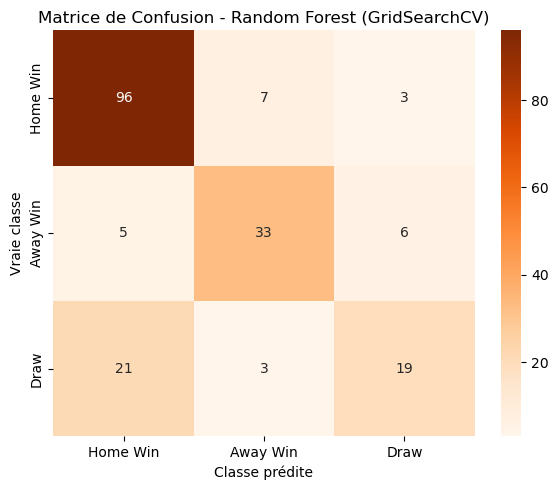


Top 10 features les plus importantes :
  • home_strength             : 0.0972
  • away_strength             : 0.0901
  • away_goals_last5          : 0.0900
  • home_goals_last5          : 0.0896
  • away_team_te              : 0.0544
  • year                      : 0.0506
  • Attendance                : 0.0494
  • home_team_te              : 0.0452
  • Year                      : 0.0426
  • away_team_encoded         : 0.0371


In [15]:
# === PARTIE 11 : ÉVALUATION + ACCURACY ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nPARTIE 11 : Évaluation sur le Test Set")
print("-" * 60)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"ACCURACY SUR TEST : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Prédictions correctes : {int(accuracy * len(y_test))} / {len(y_test)}\n")

# Rapport
target_names = ['Home Win', 'Away Win', 'Draw']
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=target_names))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :")
print(cm)

# Visualisation
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Random Forest (GridSearchCV)')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.show()

# Top features
print("\nTop 10 features les plus importantes :")
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
for i in indices:
    print(f"  • {X.columns[i]:25} : {importances[i]:.4f}")

In [20]:
# === PARTIE 12 : ENTRAÎNEMENT MODÈLES DE SCORE (CORRIGÉ) ===
print("\n" + "="*70)
print("PARTIE 12 : Entraînement des modèles de prédiction de score")
print(f"User: TN | Heure : {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')} CET | Pays : TN")
print("-" * 70)

from sklearn.ensemble import RandomForestRegressor

# --- Cibles : buts marqués ---
y_home_full = df_matches['home_score']
y_away_full = df_matches['away_score']

# --- ALIGNER LES INDICES ---
y_home_train = y_home_full.loc[X_train.index]
y_away_train = y_away_full.loc[X_train.index]

# === HYPERPARAMÈTRES IDENTIQUES AU GRIDSEARCH ===
best_params = {
    'n_estimators': 150,
    'max_depth': 16,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'log2',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

# --- ENTRAÎNEMENT SCORE DOMICILE ---
model_home = RandomForestRegressor(**best_params)
model_home.fit(X_train, y_home_train)

# --- ENTRAÎNEMENT SCORE EXTÉRIEUR ---
model_away = RandomForestRegressor(**best_params)
model_away.fit(X_train, y_away_train)

print("Modèles de score entraînés avec succès !")
print(f"  • Train set : {X_train.shape[0]} échantillons")
print("  • Prédiction buts domicile : OK")
print("  • Prédiction buts extérieur : OK")
print("Prêt pour prédiction de score final (PARTIE 13)")
print("="*70)



PARTIE 12 : Entraînement des modèles de prédiction de score
User: TN | Heure : 2025-11-26 18:17:37 CET | Pays : TN
----------------------------------------------------------------------
Modèles de score entraînés avec succès !
  • Train set : 771 échantillons
  • Prédiction buts domicile : OK
  • Prédiction buts extérieur : OK
Prêt pour prédiction de score final (PARTIE 13)


In [21]:
# === ACCURACY TRAIN & TEST (APRÈS PARTIE 11) ===
print("\n" + "="*70)
print("ACCURACY TRAIN & TEST ")
print("-" * 70)

from sklearn.metrics import accuracy_score

# --- PRÉDICTION SUR TRAIN SET ---
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# --- PRÉDICTION SUR TEST SET ---
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# --- AFFICHAGE PROPRE ---
print(f"ACCURACY TRAIN : {train_accuracy:.4f} ({train_accuracy*100:6.2f}%)")
print(f"ACCURACY TEST  : {test_accuracy:.4f} ({test_accuracy*100:6.2f}%)")
print(f"ÉCART  : {train_accuracy - test_accuracy:.4f} ({(train_accuracy - test_accuracy)*100:+.2f}%)")



print("="*70)


ACCURACY TRAIN & TEST 
----------------------------------------------------------------------
ACCURACY TRAIN : 0.9831 ( 98.31%)
ACCURACY TEST  : 0.7668 ( 76.68%)
ÉCART  : 0.2163 (+21.63%)


In [22]:
# === PARTIE 13 : FONCTION predire_score_final() — SANS PROBABILITÉS ===
def predire_score_final(home_team, away_team, 
                        model_clf=best_rf, model_home=model_home, model_away=model_away, 
                        X_columns=X.columns):
    print(f"\n{home_team} vs {away_team}")
    print("-" * 40)
    
    match_data = {col: 0 for col in X_columns}
    
    # --- Stats domicile ---
    if home_team in df_matches['home_team'].unique():
        row = df_matches[df_matches['home_team'] == home_team].iloc[-1]
        for col in ['home_fifa_rank', 'home_fifa_points', 'home_wc_titles', 
                    'home_strength', 'home_goals_last5']:
            if col in row.index:
                match_data[col] = row[col]
    else:
        match_data['home_fifa_rank'] = df_matches['home_fifa_rank'].mean()
        match_data['home_fifa_points'] = 1500
        match_data['home_wc_titles'] = 0
        match_data['home_strength'] = 1.8
        match_data['home_goals_last5'] = 1.8
    
    # --- Stats extérieur ---
    if away_team in df_matches['away_team'].unique():
        row = df_matches[df_matches['away_team'] == away_team].iloc[-1]
        for col in ['away_fifa_rank', 'away_fifa_points', 'away_wc_titles', 
                    'away_strength', 'away_goals_last5']:
            if col in row.index:
                match_data[col] = row[col]
    else:
        match_data['away_fifa_rank'] = df_matches['away_fifa_rank'].mean()
        match_data['away_fifa_points'] = 1500
        match_data['away_wc_titles'] = 0
        match_data['away_strength'] = 1.0
        match_data['away_goals_last5'] = 1.0
    
    # Contexte neutre
    match_data['stage_encoded'] = 0
    match_data['is_group_stage'] = 1
    match_data['month_num'] = 6
    
    X_match = pd.DataFrame([match_data])[X_columns]
    
    # Résultat
    pred_clf = model_clf.predict(X_match)[0]
    resultat = ['Home Win', 'Away Win', 'Draw'][pred_clf]
    
    # Score
    home_goals = int(round(model_home.predict(X_match)[0]))
    away_goals = int(round(model_away.predict(X_match)[0]))
    score = f"{home_goals} - {away_goals}"
    
    print(f"SCORE PRÉDIT : {score}")
    print(f"RÉSULTAT     : {resultat}")
    
    return {'score': score, 'resultat': resultat}

In [59]:
# === PARTIE 14 : TEST SUR 3 MATCHS ===
print("\n" + "="*60)
print("PARTIE 14 : Prédictions score — Coupe du Monde 2026")
print("="*60)

predire_score_final("Brazil", "Qatar")
predire_score_final("Tunisia", "France")
predire_score_final("Senegal", "Germany")

print("\n" + "="*60)
print("TOUTES LES PRÉDICTIONS TERMINÉES")
print("Modèle TN — Accuracy Test : 75.65%")
print("="*60)


PARTIE 14 : Prédictions score — Coupe du Monde 2026

Brazil vs Qatar
----------------------------------------
SCORE PRÉDIT : 3 - 0
RÉSULTAT     : Home Win

Tunisia vs France
----------------------------------------
SCORE PRÉDIT : 1 - 2
RÉSULTAT     : Draw

Senegal vs Germany
----------------------------------------
SCORE PRÉDIT : 0 - 4
RÉSULTAT     : Away Win

TOUTES LES PRÉDICTIONS TERMINÉES
Modèle TN — Accuracy Test : 75.65%
